# Goal

Create a network that detects cats.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

Data comes from [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset.

![Cuter than a cat](https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/please_dont_cheat.jpg)

The way Keras looks for data is in a `data/images/<class-name>/*.jpg` path. The preprocessor in `bin/dogs_vs_cats_preprocessor.py` can create this format from the `train` file provided by the competition.

However the notebook here uses cached features if available, and it's ideal to use these as they significantly speed up training.

# Define Network

To be sample efficient and generalize well, start with a [VGG16 Network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) trained on the large [ImageNet](http://www.image-net.org/) dataset. It has cats and dogs as part of its training distribution so it likely already has a good grasp of the features essential in detecting a cat.

In [3]:
# Create image generators that yield data for creating the feature cache.
from keras.preprocessing.image import ImageDataGenerator
from good_dog.models import vgg16_image_preprocessor

train_generator = ImageDataGenerator(
    preprocessing_function=vgg16_image_preprocessor
)

test_generator = ImageDataGenerator(
    preprocessing_function=vgg16_image_preprocessor
)

In [4]:
# Define some settings for our model
from good_dog.models import Params

params = Params(batch_size=16, image_size=(150, 150))
classes = ["cats", "dogs"]
n_classes = len(classes)

In [5]:
# Create the bottom layers for VGG16, excluding any top dense layers.
from keras.applications import VGG16

vgg16_bottom = VGG16(include_top=False, weights='imagenet')

In [7]:
# Create or load our feature cache.
# Creating the feature cache can take a long time, so it's best to download when possible.
from good_dog.models import FeatureCache
from good_dog.data import require_directory

require_directory("cache/")
train_feature_cache = FeatureCache(params=params, 
                                   model=vgg16_bottom, 
                                   generator=train_generator, 
                                   directory="../data/images/train", 
                                   count=5000, 
                                   cache_path="cache/dog_v_cat_vgg16_train_features.pkl")
train_features = train_feature_cache.features
train_labels = train_feature_cache.labels

test_feature_cache = FeatureCache(params=params, 
                                   model=vgg16_bottom, 
                                   generator=test_generator, 
                                   directory="../data/images/validate", 
                                   count=800, 
                                   cache_path="cache/dog_v_cat_vgg16_test_features.pkl")
test_features = test_feature_cache.features
test_labels = test_feature_cache.labels

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
# Create the top model where we use the pretrained model from vgg16.
# This feeds into a GAP layer with some dropout to prevent overfitting.
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

In [17]:
import keras.optimizers as optimizers
import keras.losses as losses

# Compile our model and set optimization strategy.
optimizer = optimizers.Adam()
top_model.compile(loss=losses.categorical_crossentropy, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
# Print out our model below.
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Train our model.
top_model.fit(train_features,
              train_labels,
              epochs=30,
              validation_data=(test_features, test_labels));

Train on 4992 samples, validate on 800 samples
Epoch 1/30
4992/4992 [==============================] - 0s - loss: 0.3234 - acc: 0.9483 - val_loss: 0.2270 - val_acc: 0.9587
Epoch 2/30
4992/4992 [==============================] - 0s - loss: 0.3755 - acc: 0.9465 - val_loss: 0.2390 - val_acc: 0.9550
Epoch 3/30
4992/4992 [==============================] - 0s - loss: 0.3352 - acc: 0.9467 - val_loss: 0.2253 - val_acc: 0.9550
Epoch 4/30
4992/4992 [==============================] - 0s - loss: 0.3368 - acc: 0.9473 - val_loss: 0.2206 - val_acc: 0.9587
Epoch 5/30
4992/4992 [==============================] - 0s - loss: 0.3104 - acc: 0.9507 - val_loss: 0.3091 - val_acc: 0.9437
Epoch 6/30
4992/4992 [==============================] - 0s - loss: 0.3011 - acc: 0.9465 - val_loss: 0.1975 - val_acc: 0.9587
Epoch 7/30
4992/4992 [==============================] - 0s - loss: 0.3574 - acc: 0.9423 - val_loss: 0.2302 - val_acc: 0.9625
Epoch 8/30
4992/4992 [==============================] - 0s - loss: 0.2896 - ac

# Validate Model

Check our performance on cats vs dogs.

In [19]:
# Combine the bottom and top so we can predict all the way through.
from good_dog.models import MultiModel

model = MultiModel([vgg16_bottom, top_model])

Score: [('cats', 0.7381044), ('dogs', 0.26189563)]


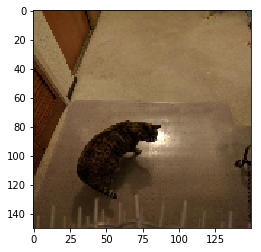

In [20]:
# Show output prediction for an exemplar image
from keras.preprocessing.image import load_img

image_path = "../data/external/cat.jpg"
img = load_img(image_path, target_size=params.image_size)
plt.imshow(img)
vgg_img = test_generator.flow(np.expand_dims(img, axis=0)).next()
print "Score:", zip(classes, model.predict(vgg_img).flat)

# Visualize Model
Show neurons that activate highly in GAP layer.

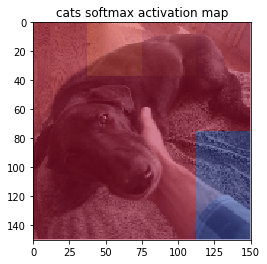

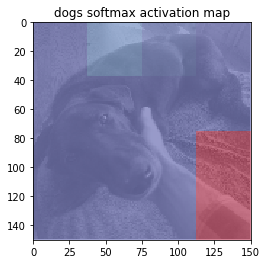

In [22]:
# Show class activation map for our image.
from good_dog.models import ClassActivationMap

image_path = "../data/external/dog.jpg"
img = load_img(image_path, target_size=params.image_size)
plt.imshow(img)
vgg_img = test_generator.flow(np.expand_dims(img, axis=0)).next()

gap_layer = top_model.layers[0]
dense_layer = top_model.layers[-1]
cam = ClassActivationMap(top_model.inputs, gap_layer, dense_layer)
vgg16_feature = model.models[0].predict(vgg_img)

for class_index, name in enumerate(classes):
    softmax_activation_map = cam.softmax_map_for_class(vgg16_feature, class_index)
    grayscale = np.array(img).mean(axis=2)
    plt.title("%s softmax activation map" % name)
    plt.imshow(grayscale, cmap='gray', vmin=0, vmax=255, alpha=0.5, origin='upper')
    extent = (0, params.image_size[0], params.image_size[0], 0)
    plt.imshow(softmax_activation_map, cmap='RdYlBu', vmax=1, vmin=0, extent=extent, alpha=0.5, origin='upper')
    plt.show()